In [145]:
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import csr_matrix, hstack
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.feature_selection import VarianceThreshold
import pickle

In [146]:
dir_in = 'data'

In [147]:
gatrain = pd.read_csv(os.path.join(dir_in,'gender_age_train.csv'))
targetencoder = LabelEncoder().fit(gatrain.group)
y = targetencoder.transform(gatrain.group)
nclasses = len(targetencoder.classes_)

In [148]:
feature_files = ['features_bag_brand',
                 'features_bag_model',
                'features_bag_label_installed',
                'features_bag_app_installed']

In [608]:
def plot_all_features_group(X,y, cols=None, agg = 'mean'):
    if cols == None: cols = X.columns[1:]
    for c in cols:
        plt.figure()
        plot_feat_group(X,y, c,agg)

def plot_feat_group(X,y, feat, agg = 'mean'):
    y_i = pd.DataFrame(targetencoder.inverse_transform(y),columns=['group'])
    to_plot = pd.concat([X[feat],y_i], axis=1)
    to_plot.groupby('group')[feat].agg(agg).plot(kind='barh')
    plt.title(feat)
    
def plot_corr(X):
    sns.heatmap(X.corr(), annot=True)

## Load features calculated my dune dweller

In [149]:
def open_feature_file(fname, samples='train'):
    with open(os.path.join(dir_in, '{}_{}.pickle'.format(fname,samples)), 'rb') as f:
        return pickle.load(f)
    

In [631]:
Xtrain = hstack([open_feature_file(f) for f in feature_files],format='csr')

In [632]:
Xtrain.shape

(74645, 21527)

In [490]:
def normalize(x):
    return (x - x.min())/(x.max() - x.min())

In [647]:
# Calculate CV score on Xtrain, y
def score(X, clf = None, random_state = 12):
    if not clf: clf = LogisticRegression(C=0.02, multi_class='multinomial',solver='lbfgs', n_jobs=3)
        
    kf = StratifiedKFold(y, n_folds=5, shuffle=True, random_state=random_state)
    pred = np.zeros((y.shape[0],nclasses))
    for itrain, itest in kf:
        Xtr, Xte = X[itrain, :], X[itest, :]
        ytr, yte = y[itrain], y[itest]
        clf.fit(Xtr, ytr)
        pred[itest,:] = clf.predict_proba(Xte)
        # Downsize to one fold only for kernels
        #print("{:.5f}".format(log_loss(yte, pred[itest,:])))
    #print('')
    return log_loss(y, pred)

# Calculate score per feature in feature set X_feat
def score_per_feature_individual(feat_set, cols = None):
    # Skip first column, assumed to be device_id
    if cols == None: cols = feat_set.columns[1:]
        
    for c in cols:
        print c
        Xtrain = hstack([open_feature_file(f) for f in feature_files],format='csr')
        Xtrain = hstack([Xtrain, csr_matrix(feat_set[[c]].values)], format='csr')
        newscore = score(Xtrain)
        print newscore, basescore - newscore
        print ''
        
# Calculate score for incrementally adding feature in feature set X_feat
def score_per_feature_incremental(feat_set, cols = None):
    # Skip first column, assumed to be device_id
    if cols == None: cols = feat_set.columns[1:]
        
    for i in range(len(cols)):
        c = cols[0:(i+1)]
        print c
        Xtrain = hstack([open_feature_file(f) for f in feature_files],format='csr')
        Xtrain = hstack([Xtrain, csr_matrix(feat_set[c].values)], format='csr')
        newscore = score(Xtrain)
        print newscore, basescore - newscore
        print ''

In [153]:
# Get a base score on this feature set
basescore = score(Xtrain)
print basescore


2.27451850131


In [654]:
Xtrain = hstack([open_feature_file(f) for f in feature_files],format='csr')
selector = VarianceThreshold(0.00005)
Xtrain = selector.fit_transform(Xtrain)
n = 9
delta = 0
for s in np.random.choice(99999, n):
    newscore = score(Xtrain, random_state=s)
    delta += (basescore - newscore)/n
    print s,':',newscore, basescore - newscore
print('Average result: {:.5f}'.format(delta))

26847 : 2.27325867991 0.00125982140249
17471 : 2.2742276778 0.000290823506405
84843 : 2.27347299269 0.00104550861627
83179 : 2.27412398007 0.000394521239171
20079 : 2.27397895248 0.000539548825296
78911 : 2.27347196104 0.00104654027113
20476 : 2.27459578183 -7.7280523628e-05
3280 : 2.27345253202 0.00106596928623
79865 : 2.27388327474 0.000635226574452
Average result: 0.00069


0.00001: 0.00026
0.00005: 0.00069
0.0001: 0.000335887419548
0.0002:
0.0005: -0.00049


## Load geo features
- Base core: 2.27451850131
- Adding zeros (same number as features): 2.27451850186
- Adding one zero: 2.27451850166
- Adding all features increases logloss to: 2.32091595903, -0.046397
- Adding all close_to features: (+3.0601009999742246e-05)
- Adding close to city feature: 2.27454510239, -2.66010811991e-05
- Adding travel_dist: 2.27456104213, -4.2540819968e-05
- Adding normalized travel_dist: 2.27452102419-2.52288361002e-06
- Per close to feature: positive: close_to_guangzhou, close_to_hongkong, close_to_nanjing, close_to_harbin,close_to_chongqin
- Guangzhou / hongkong very correlated, so removed hongkong: +8.16538384645e-05

In [468]:
feat_geo = pd.read_csv(os.path.join(dir_in,'features_geo.csv'))
feat_geo['travel_dist'] = normalize(feat_geo['travel_dist'])

dist_cols = list(feat_geo.filter(regex=('dist_.*')).columns.values)
close_cols = list(feat_geo.filter(regex=('close_to.*')).columns.values)
feat_geo['close_to_city'] = feat_geo[close_cols].any(axis=1).astype(int)

feat_geo = gatrain[['device_id']].merge(feat_geo, on='device_id', how='left')
feat_geo.fillna(0, inplace=True)

In [469]:
feat_geo.shape

(74645, 27)

In [470]:
feat_geo.head()

,device_id,dist_beijing,close_to_beijing,dist_guangzhou,close_to_guangzhou,dist_chengdu,close_to_chengdu,dist_tianjin,close_to_tianjin,dist_hongkong,...,dist_wuhan,close_to_wuhan,dist_shanghai,close_to_shanghai,dist_harbin,close_to_harbin,dist_chongqing,close_to_chongqing,travel_dist,close_to_city
0,-8076087639492063270,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-2897161552818060146,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-8260683887967679142,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-4938849341048082022,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,245133531816851882,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [486]:
cols_to_include = ['close_to_guangzhou', 'close_to_nanjing', 
                   'close_to_harbin', 'close_to_chongqing']
Xtr_geo = csr_matrix(feat_geo[cols_to_include].values)

In [473]:
for c in close_cols:
    print c
    Xtrain = hstack([open_feature_file(f) for f in feature_files],format='csr')
    Xtrain = hstack([Xtrain, csr_matrix(feat_geo[[c]].values)], format='csr')
    newscore = score(LogisticRegression(C=0.02, multi_class='multinomial',solver='lbfgs'))
    print newscore
    print basescore - newscore
    

close_to_beijing
2.27454304797
-2.45466587563e-05
close_to_guangzhou
2.274440832
7.76693071187e-05
close_to_chengdu
2.27454893001
-3.04287011912e-05
close_to_tianjin
2.27454645679
-2.79554781542e-05
close_to_hongkong
2.27449085309
2.76482223942e-05
close_to_shenyang
2.27452185263
-3.35132455254e-06
close_to_xian


KeyboardInterrupt: 

In [481]:
score_per_feature_individual(feat_geo, close_cols)

close_to_beijing
2.27454304797 -2.45466587563e-05

close_to_guangzhou
2.274440832 7.76693071187e-05

close_to_chengdu
2.27454893001 -3.04287011912e-05

close_to_tianjin


KeyboardInterrupt: 

In [489]:
score_per_feature_incremental(feat_geo, cols_to_include)

['close_to_guangzhou']
2.274440832 7.76693071187e-05

['close_to_guangzhou', 'close_to_nanjing']
2.27444070262 7.7798687756e-05

['close_to_guangzhou', 'close_to_nanjing', 'close_to_harbin']
2.27443815671 8.03445950908e-05

['close_to_guangzhou', 'close_to_nanjing', 'close_to_harbin', 'close_to_chongqing']
2.27443684747 8.16538384645e-05



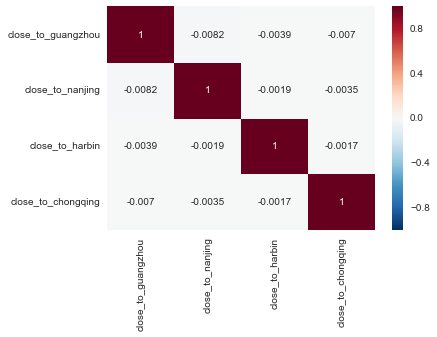

In [488]:
sns.heatmap(feat_geo[cols_to_include].corr(), annot=True)

In [306]:
# See what happens when we add this to all features
Xtrain = hstack([open_feature_file(f) for f in feature_files],format='csr')
Xtrain = hstack([Xtrain, Xtr_geo], format='csr')

In [307]:
newscore = score(LogisticRegression(C=0.02, multi_class='multinomial',solver='lbfgs'))
print newscore
print basescore - newscore


2.27454582783
-2.73265156414e-05


In [235]:
vs=np.arange(0,0.0005,0.0001)
print Xtrain.shape
for v in vs: 
    Xtrain = hstack([open_feature_file(f) for f in feature_files],format='csr')
    selector = VarianceThreshold(v)
    Xtrain = selector.fit_transform(Xtrain)
    print Xtrain.shape
    newscore =  score(LogisticRegression(C=0.02, multi_class='multinomial',solver='lbfgs'))
    print newscore
    print basescore - newscore

(74645, 21527)
(74645, 15853)

2.27451850186
-5.52712542401e-10
(74645, 5671)

2.27470283073
-0.000184329423639
(74645, 4234)

2.27495353635
-0.000435035044096
(74645, 3484)


KeyboardInterrupt: 

In [217]:
np.arange(0.01,0.07,10)

array([ 0.01])

## Number of events
- Adding all features increased score by -0.087270312158
- Before normalizing only n day events has positive impact (measuring each individually)
- After normalizing all had a small impact except the means (measuring each individually)
- Adding all after normalization: 0.000273318114596
- Adding all with positive contribution after normalization: 2.27425038193, +0.000268119380904
- Adding all with logarithmic scaling + normalization: +0.000199616075073
- Best results with normalization and three features: ['n day events', 'n event sum']

In [497]:
feat_events = pd.read_csv(os.path.join(dir_in,'features_event.csv'))

# Extreme values
feat_events['n event hour max'][feat_events['n event hour max']>500]=500

for c in feat_events.columns[1:]:
    feat_events[c] = np.log(feat_events[c])
    feat_events[c] = normalize(feat_events[c])
    
feat_events = gatrain[['device_id']].merge(feat_events, on='device_id', how='left')
feat_events.fillna(0, inplace=True)



/Users/joostbloom/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [498]:
feat_events.shape

(74645, 10)

In [499]:
print feat_events.columns

Index([u'device_id', u'n day events', u'n hour events', u'n event sum',
       u'n event day max', u'n event day mean', u'n event day std',
       u'n event hour max', u'n event hour mean', u'n event hour std'],
      dtype='object')


In [501]:
feat_events.head()

,device_id,n day events,n hour events,n event sum,n event day max,n event day mean,n event day std,n event hour max,n event hour mean,n event hour std
0,-8076087639492063270,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-2897161552818060146,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-8260683887967679142,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-4938849341048082022,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,245133531816851882,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [502]:
feat_events.describe()

,device_id,n day events,n hour events,n event sum,n event day max,n event day mean,n event day std,n event hour max,n event hour mean,n event hour std
count,7.464500e+04,74645.000000,74645.000000,74645.000000,74645.000000,74645.000000,74645.0,74645.000000,74645.000000,74645.0
mean,-7.491354e+14,0.180291,0.164112,0.081228,0.070534,0.056522,0.0,0.081694,0.044841,0.0
std,5.327150e+18,0.332781,0.305619,0.149065,0.136783,0.113716,0.0,0.162343,0.095114,0.0
min,-9.223067e+18,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
25%,-4.617367e+18,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
50%,-1.841362e+16,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
75%,4.636656e+18,0.000000,0.218104,0.105463,0.080624,0.048631,0.0,0.111535,0.018446,0.0
max,9.222849e+18,1.000000,1.000000,0.799730,0.920509,0.765798,0.0,1.000000,0.717808,0.0


In [503]:
Xtr_events = csr_matrix(feat_events[cols_to_include].values)

In [504]:
# See what happens when we add this to all features
Xtrain = hstack([open_feature_file(f) for f in feature_files],format='csr')
Xtrain = hstack([Xtrain, Xtr_events], format='csr')

In [429]:
newscore = score(LogisticRegression(C=0.02, multi_class='multinomial',solver='lbfgs'))
print newscore
print basescore - newscore


2.27431888523
0.000199616075073


In [516]:
cols_to_include = ['n day events', 'n event sum',
       'n event day max']

In [512]:
score_per_feature_individual(feat_events, cols_to_include)

n day events
2.27426864879 0.000249852515187

n event sum
2.27433646025 0.000182041063291

n event day max
2.27441733911 0.000101162200969

n event hour max
2.27436072238 0.000157778927346



In [515]:
score_per_feature_incremental(feat_events, cols_to_include)

['n day events']
2.27426864879 0.000249852515187

['n day events', 'n event sum']
2.27418695525 0.000331546057913

['n day events', 'n event sum', 'n event hour max']
2.27422528365 0.000293217662606



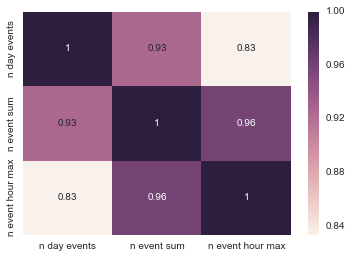

In [514]:
plot_corr(feat_events[cols_to_include])

In [276]:
# What happens if we weight each sample with one of the columns?

## Active apps
- Without transformation a very tiny improvement (9e-5): 9.83873071472e-05
- With variancethreshold of 0.00001: 7.93861259898e-05 
- After binarizing with treshold 0.5: -0.00034298923427 (var tresh: 0)
- After binarizing with treshold 0.25: -0.00034298923427 (var tresh: 0)
- After binarizing with treshold 0.05 (no var tresh): -0.00034298923427

In [517]:
from sklearn.preprocessing import binarize

In [518]:
binarize(0, threshold=0.05)

array([[0]])

In [628]:
X_act = open_feature_file('features_bag_app_active')
#X_act = binarize(X_act.todense(), threshold=0.5)
selector = VarianceThreshold(0.0001)
X_act = selector.fit_transform(X_act)
X_act.shape

(74645, 1494)

In [629]:
Xtrain = hstack([open_feature_file(f) for f in feature_files],format='csr')
Xtrain = hstack([Xtrain, X_act], format='csr')

In [630]:
for s in [0,123, 1234, 123456]:
    newscore = score(Xtrain, random_state=s)
    print newscore
    print basescore - newscore

2.2744446251
7.38762138552e-05
2.27395619772
0.000562303587308
2.27344752024
0.00107098107083
2.27448643551
3.20658022352e-05


In [588]:
X_act = X_act.todense()

In [589]:
cols_to_include = np.random.choice(X_act.shape[1], 10)
print cols_to_include

[296 406 313 362 235 341 248 261 170 301]


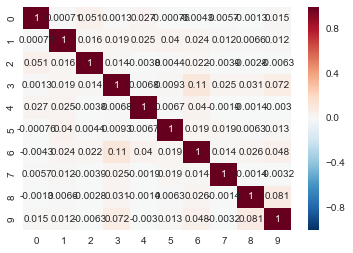

In [590]:
plot_corr(pd.DataFrame(X_act[:, cols_to_include]))

In [591]:
pd.DataFrame(X_act[:, cols_to_include]).sum()

0    1000.721500
1     272.148241
2     583.000000
3     234.709525
4     135.000000
5      99.913248
6     982.801808
7     147.000000
8      76.333333
9     379.002455
dtype: float64

In [623]:
score_per_feature_individual(pd.DataFrame(X_act), cols_to_include)

/Users/joostbloom/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:20: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


296
2.27350107722 0.00101742409141

406
2.2735508079 0.000967693405145

313
2.27354254577 0.000975955543632

362
2.27354325729 0.000975244019101

235
2.27350523839 0.00101326292044

341


KeyboardInterrupt: 

In [ ]:
296
2.27448551786 3.29834484134e-05

406
2.27452281754 -4.31622702379e-06

313
2.2745179335 5.67812269203e-07

362
2.27450480969 1.36916177067e-05

235
2.27455242847 -3.39271551697e-05

341
2.27449874626 1.97550487866e-05

248
2.27456460383 -4.61025222145e-05

261
2.27451132115 7.18015889145e-06

170
2.27450310532 1.53959905358e-05

301
2.27448963687 2.88644396478e-05

In [593]:
from scipy.stats import linregress
from scipy.stats.stats import pearsonr

In [614]:
for c in cols_to_include:
    print c,linregress(np.ravel(X_act[:, c]),y )

296 LinregressResult(slope=1.1089339371808815, intercept=6.3911751084016899, rvalue=0.035607202592794422, pvalue=2.2184761362270434e-22, stderr=0.11391942553535768)
406 LinregressResult(slope=0.94677086275556699, intercept=6.402590099473584, rvalue=0.015155073569386694, pvalue=3.4621431246024831e-05, stderr=0.22863484135080719)
313 LinregressResult(slope=-1.0540686948439171, intercept=6.4142745267478602, rvalue=-0.027408379917477316, pvalue=6.9089110455747684e-14, stderr=0.14071092571659941)
362 LinregressResult(slope=0.37822333264172558, intercept=6.4048526677106175, rvalue=0.0051574563350893724, pvalue=0.1588154609770342, stderr=0.26841849576479659)
235 LinregressResult(slope=0.84734239003464296, intercept=6.4045094618172058, rvalue=0.010634462751840386, pvalue=0.0036666651640055651, stderr=0.29162468120579316)
341 LinregressResult(slope=0.11994253136993703, intercept=6.4058813872606439, rvalue=0.0011445287589262661, pvalue=0.75451293979027423, stderr=0.38357621829119432)
248 Linregr

In [601]:
for c in cols_to_include:
    print c,pearsonr(np.ravel(X_act[:, c]),y )

296 (0.035607202592794429, 2.2184761363437963e-22)
406 (0.015155073569386677, 3.4621431247870489e-05)
313 (-0.027408379917477268, 6.9089110459398684e-14)
362 (0.005157456335089382, 0.15881546098565127)
235 (0.010634462751840417, 0.0036666651642124782)
341 (0.0011445287589262596, 0.75451293977313239)
248 (0.047836395457638188, 4.4708185872155471e-39)
261 (0.0054726355186592987, 0.13486802338489484)
170 (0.011779590645966289, 0.0012891346146539824)
301 (0.013752270823743851, 0.00017168432565815346)


In [613]:
(pd.DataFrame(X_act[:, cols_to_include])>0).sum()

0    1270
1     466
2     583
3     480
4     135
5     171
6    1539
7     147
8      77
9     383
dtype: int64

In [616]:
a = pd.DataFrame(X_act)

In [617]:
a.head()

,0,1,2,3,4,5,6,7,8,9,...,397,398,399,400,401,402,403,404,405,406
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


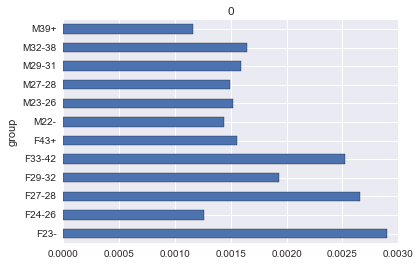

In [618]:
plot_feat_group(a,y,0)

/Users/joostbloom/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  from ipykernel import kernelapp as app


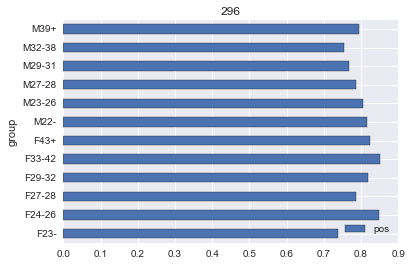

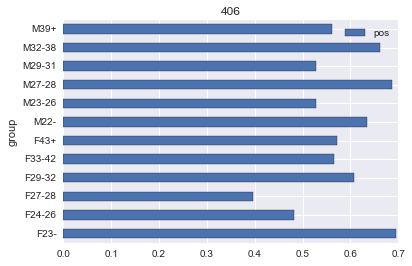

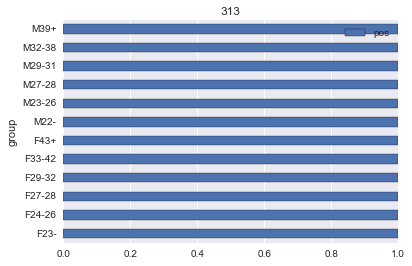

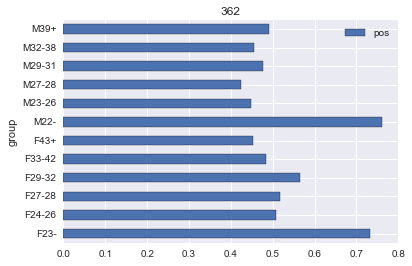

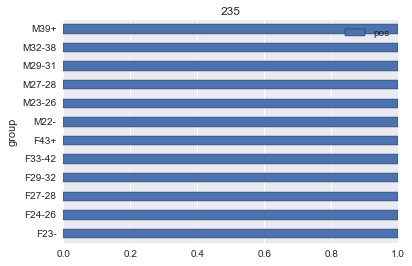

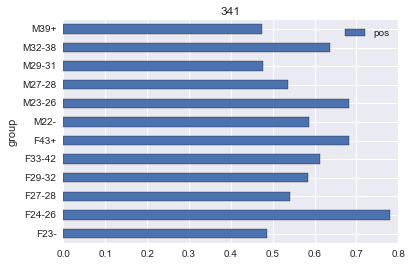

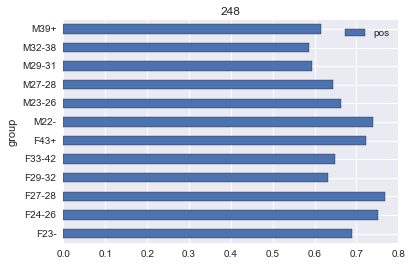

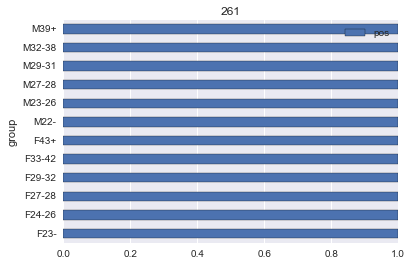

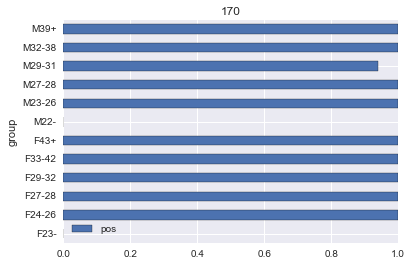

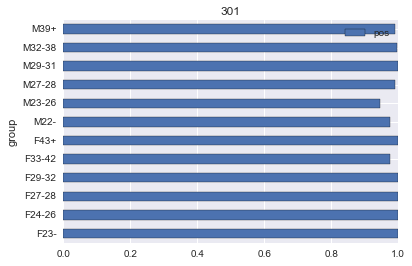

In [620]:
plot_all_features_group(a,y,cols_to_include, agg = {'pos':lambda ts: ts[ts > 0].mean()})

In [621]:
cols_to_include

array([296, 406, 313, 362, 235, 341, 248, 261, 170, 301])

In [ ]:
a